<a href="https://colab.research.google.com/github/joshuahm/generacion_de_texto/blob/master/Generacion_de_texto_RIIAA_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Taller de generacion de texto**
 
Ejecutar *este* notebook via colab:
<a href="https://colab.research.google.com/github/joshuahm/generacion_de_texto/blob/master/notebooks/1_Colab_ejemplo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instala los requerimientos

In [4]:
%%capture
import os
import tensorflow as tf
import numpy as np
!pip install transformers
!pip install textualheatmap
from transformers import BertTokenizer, TFBertForMaskedLM
import collections
!pip install markovify
import markovify

In [6]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


# Introduccion

En este taller hablaremos de **Generación de Texto**, describiremos la tarea y construiremos una *intuicion* sobre porque esta tarea es interesante y complicada. 
Describiremos los avances que se han visto en los ultimos años y daremos un vistazo al estado-del-arte de generacion de texto en español.


Este taller esta escrito en Python y usa diferentes librerías y frameworks como Tensorflow, huggingface, PEGASUS. Asumimos que el lector tiene conocimiento de este lenguaje y tiene idea general de aprendizaje de maquinas.

# Carga los datos

Descarga *\"La iliada\"*

In [40]:
# La Iliada
path_a = tf.keras.utils.get_file('57654-0.txt', 'https://www.gutenberg.org/files/57654/57654-0.txt')
iliada = open(path_a, 'rb').read().decode(encoding='utf-8')

# Vamos a limpiar el texto.

# Removamos la descripción.
iliada = iliada.split('AL LECTOR', maxsplit=1)[1]
# Removamos doble espacios y doble salto de pagina. Tambien removamos los artificios de cursivas, etc.
unchanged = False
while not unchanged:
  new_iliada = iliada.replace('\n\n\n', '\n\n')
  new_iliada = new_iliada.replace('  ', ' ')
  new_iliada = new_iliada.replace('_', '')
  new_iliada = new_iliada.replace('\r', '')
  unchanged = new_iliada == iliada
  iliada = new_iliada

print(iliada[:1000])

1138688/1131399 [==============================] - 1s 1us/step


No sin temor pongo en tus manos esta versión en prosa del inmortal
poema homérico compuesto hace treinta siglos[1] y no superado aún por
otro alguno; epopeya sin par y cuadro fiel de los orígenes históricos
de aquella cultura helénica que tanto influyó en la romana, y más
tarde, ya directamente, ya por medio de esta última, en la de casi
todos los pueblos civilizados.

Sabido es que la Ilíada tiene por asunto un episodio de la guerra de
Troya, ocurrido en el noveno año de la misma[2]; y que se atribuye á
Homero, el padre de la poesía, el célebre aedo que recorría la Grecia
cantando al son de la cítara sus propias composiciones. No es posible
hablar en estas pocas líneas de la llamada cuestión homérica[3],
ni resumir lo que han dicho los críticos sobre la existencia[4] y la
patria de Homero[5], las obras que compuso[6] y el estado en que han
llegado hasta nosotros[7]. Por tanto, sólo manifestaré las razones que
me impulsar

Descarga *\"La divina comedia\"*

In [41]:
# La Divina Comedia
path_b = tf.keras.utils.get_file('pg57303.txt', 'http://www.gutenberg.org/cache/epub/57303/pg57303.txt')
divina_comedia = open(path_b, 'rb').read().decode(encoding='utf-8')

# Vamos a limpiar el texto.

# Removamos la descripción.
divina_comedia = divina_comedia.split('[Ilustración]', maxsplit=1)[1]

# Removamos doble espacios y doble salto de pagina. Tambien removamos los artificios de cursivas, etc.
unchanged = False
while not unchanged:
  new_divina_comedia = divina_comedia.replace('\n\n\n', '\n\n')
  new_divina_comedia = new_divina_comedia.replace('  ', ' ')
  new_divina_comedia = new_divina_comedia.replace('_', '')
  new_divina_comedia = new_divina_comedia.replace('=', '')
  new_divina_comedia = new_divina_comedia.replace('\r', '')
  unchanged = new_divina_comedia == divina_comedia
  divina_comedia = new_divina_comedia

print(divina_comedia[:1000])

745472/741235 [==============================] - 0s 0us/step


 Universidad Nacional
 de México.
 1921

[Ilustración]

"LA COMMEDIA"

¿Que es pues la Comedia? La edad medieval realizada como arte, a pesar
del autor y de los contemporáneos. ¡Y notad qué cosa tan grande es
ésta! La edad media no era un mundo artístico, antes lo contrario del
arte. La religión era misticismo; la filosofía, escolástica. La primera
excomulgaba el arte, quemaba las imágenes, avezaba a los espíritus a
desasirse de lo real. La otra vivía de abstracciones y de fórmulas y
de citas, aguzando el entendimiento y llevándole a sutilizar acerca
de los nombres y de los vacuas generalidades llamadas esencias. Los
espíritus eran atraídos hacia lo general, más dispuestos a idealizar
que a realizar: y esto es precisamente lo contrario del arte. En los
poetas sencillos hallamos la realidad tosca e informe, como en los
misterios, en las visiones y en las leyendas. En los poetas doctos
encontramos una forma crudamente didascá

## Discusion

*   Que diferencias esperan en texto de los dos libros cargados?

# Modelando lenguaje: Introducción






Antes de meternos de lleno en generación de texto. Analicemos los datos y veamos por que es interesante generar texto.

Empezaremos viendo la frequencia de palabras en los dos libros que cargamos

In [47]:
def get_unigram_frequency(text, topk=20):
  lineas = text.split('\n')
  # Contador de palabras
  palabras = collections.Counter() 
  for l in lineas:
    for p in l.split(' '):
      palabras[p] += 1
  return palabras.most_common(topk)

In [48]:
get_unigram_frequency(iliada)

[('de', 9276),
 ('y', 7459),
 ('á', 6307),
 ('la', 5544),
 ('', 5535),
 ('los', 4836),
 ('el', 4823),
 ('que', 4468),
 ('en', 3628),
 ('las', 1964),
 ('por', 1897),
 ('con', 1882),
 ('se', 1872),
 ('del', 1660),
 ('al', 1523),
 ('su', 1254),
 ('no', 1151),
 ('le', 1068),
 ('un', 1026),
 ('para', 897)]

In [49]:
get_unigram_frequency(divina_comedia)

[('de', 5284),
 ('que', 5266),
 ('y', 3606),
 ('la', 3593),
 ('el', 3132),
 ('', 2845),
 ('a', 2705),
 ('en', 2535),
 ('se', 1726),
 ('por', 1498),
 ('los', 1428),
 ('no', 1280),
 ('su', 1128),
 ('las', 1046),
 ('me', 1029),
 ('del', 1022),
 ('con', 971),
 ('lo', 895),
 ('un', 772),
 ('como', 749)]

Aqui podemos ver que ciertas palabras ocurren con alta frequencia en la mayoria de los textos. Lo que estamos comparando se llama frequencia de **unigrams**. Otra forma de decir palabras (**-grams**) de un solo (**uni-**) componente.

Unigrams son solo un pedazo de la historia, en realidad no nos dicen nada sobre el orden de las palabras. El significado del texto depende mucho no solo del contenido pero la sequencia de las palabras.

**N-grams** son sequencias de unidades de texto (e.g. caracteres, palabras) parte de otras sequencias mas largas (e.g. un enunciado, parrafo).

Por ejemplo, si la unidad de texto son caracteres los trigrams de la sequencia "*Mexico*" son: "*Mex*", "*exi*", "*ico*".

Si la unidad de texto son palabras, los 5-grams del enunciado:

"*RIIAA reúne el ecosistema de inteligencia artificial mexicano y latinoamericano*"

incluyen:


*   "*RIIAA reúne el ecosistema de*"
*   "*reúne el ecosistema de inteligencia*"
*   "*el ecosistema de inteligencia mexicano*"
*   "*inteligencia artificial mexicano y latinoamericano*"
*   ...

In [50]:
def get_ngrams_count(text, n, topk=20):
  ngrams = []
  for linea in text.split('\n'):
    linea_palabras = [p for p in linea.split(' ') if p]
    ngrams.extend(
        [tuple(linea_palabras[idx : idx + n])
         for idx in range(len(linea_palabras) - n)])
  return collections.Counter(ngrams).most_common(topk)

In [51]:
get_ngrams_count(iliada, n=5)

[(('Aquiles,', 'el', 'de', 'los', 'pies'), 43),
 (('Una', 'de', 'las', 'nereidas,', 'XVIII,'), 33),
 (('el', 'de', 'los', 'pies', 'ligeros,'), 21),
 (('de', 'Júpiter,', 'que', 'lleva', 'la'), 17),
 (('el', 'de', 'los', 'pies', 'ligeros:'), 16),
 (('Juno,', 'la', 'diosa', 'de', 'los'), 15),
 (('la', 'diosa', 'de', 'los', 'níveos'), 15),
 (('divino', 'Aquiles,', 'el', 'de', 'los'), 15),
 (('Minerva,', 'la', 'diosa', 'de', 'los'), 14),
 (('la', 'diosa', 'de', 'los', 'brillantes'), 14),
 (('diosa', 'de', 'los', 'níveos', 'brazos,'), 13),
 (('Juno', 'veneranda,', 'la', 'de', 'los'), 13),
 (('Ciudad', 'de', 'la', 'isla', 'de'), 13),
 (('el', 'divino', 'Aquiles,', 'el', 'de'), 12),
 (('veneranda,', 'la', 'de', 'los', 'grandes'), 12),
 (('Júpiter,', 'que', 'lleva', 'la', 'égida,'), 11),
 (('de', 'los', 'hombres', 'y', 'de'), 11),
 (('los', 'hombres', 'y', 'de', 'los'), 10),
 (('palabras', 'les', 'excitó', 'á', 'todos'), 10),
 (('les', 'excitó', 'á', 'todos', 'el'), 10)]

In [52]:
get_ngrams_count(divina_comedia, n=5)

[(('a', 'uno', 'y', 'otro', 'lado'), 4),
 (('no', 'es', 'más', 'que', 'una'), 3),
 (('de', 'tal', 'suerte,', 'que', 'no'), 3),
 (('Tales', 'fueron', 'las', 'palabras', 'de'), 3),
 (('se', 'volvió', 'hacia', 'la', 'derecha,'), 3),
 (('que', 'en', 'otro', 'tiempo', 'fué'), 3),
 (('desde', 'el', 'sitio', 'en', 'que'), 3),
 (('de', 'tal', 'modo,', 'que', 'no'), 3),
 (('de', 'tal', 'modo', 'que', 'no'), 3),
 (('en', 'mí', 'el', 'deseo', 'de'), 3),
 (('a', 'fin', 'de', 'que', 'su'), 3),
 (('not', 'protected', 'by', 'U.S.', 'copyright'), 3),
 (('Project', 'Gutenberg', 'Literary', 'Archive', 'Foundation'), 3),
 (('lo', 'humano', 'a', 'lo', 'divino,'), 2),
 (('de', 'la', 'anarquía', 'a', 'la'), 2),
 (('que', 'no', 'es', 'más', 'que'), 2),
 (('es', 'la', 'que', 'me', 'ha'), 2),
 (('dispuesto', 'allí', 'donde', 'se', 'puede'), 2),
 (('y', 'me', 'hizo', 'entrar', 'en'), 2),
 (('oí', 'una', 'voz', 'que', 'decía:'), 2)]

N-grams son usados en procesamiento de texto natural y viendo la frequencia con la que aparecen sequencias de palabras, surgen varias preguntas:

*   Dado una sequencia de palabras, que palabra seguirá despues?

Podemos estimar esto a mano.



In [53]:
prefix_tuple = ('otro', 'lado')

def next_word_from_tuple(text, prefix_tuple):
  return [
    (tupl, freq) for tupl, freq in get_ngrams_count(text, n=len(prefix_tuple) + 1, topk=10**10)
    if tupl[:len(prefix_tuple)] == prefix_tuple]

print('Iliada')
print(next_word_from_tuple(iliada, prefix_tuple))

print('\nDivina comedia')
print(next_word_from_tuple(divina_comedia, prefix_tuple))
print()

Iliada
[(('otro', 'lado', 'del'), 2), (('otro', 'lado', 'fué'), 1), (('otro', 'lado', 'cerca'), 1)]

Divina comedia
[(('otro', 'lado', 'de'), 2), (('otro', 'lado', 'del'), 2), (('otro', 'lado', 'las'), 1), (('otro', 'lado', 'mira'), 1), (('otro', 'lado', 'el'), 1), (('otro', 'lado', 'a'), 1), (('otro', 'lado', 'estaban'), 1), (('otro', 'lado', 'para'), 1)]



Es posible ver que la frequencia es diferente para diferentes textos. Esta distribucion de palabras depende del dominio del texto y cambia con el tiempo, palabras se vuelven más comunes o van en deuso.

Por ejemplo, es mucho mas probable que "canasta" siga de "anotó la" en un texto de deportes que en un texto de historia.

<br>

\begin{equation*}
P_{deportes}(\mbox{canasta}| \mbox{anoto, la}) > P_{historia}(\mbox{canasta} | \mbox{anoto, la} )
\end{equation*}

<br>

Pensando en probabilidades, la frequencia de sequencias de palabras nos dice lo siguiente:

\begin{equation}
P(\mbox{palabra} | \mbox{sequencia}) \approx \frac{\sum\mbox{veces que palabra sigue a sequencia}}{\sum{\mbox{sequencia seguida por cualquier palabra}}}
\end{equation}

<br>

Esto es la base del modelo estadistico lenguaje.

In [59]:
generator_iliada = markovify.Text(iliada, state_size=3)
generator_divina_comedia = markovify.Text(divina_comedia, state_size=3)

In [61]:
print(generator_iliada.make_sentence())
print(generator_divina_comedia.make_sentence())

Sed hombres y mostrad que tenéis un corazón pundonoroso, y avergonzaos de parecer cobardes en el duro combate, vencido por las manos y la espada se le rompió junto á la negra muerte los arrastraba.
Así como en un espejo.


Ahora demosle una palabra para empezar el enunciado.

In [74]:
print(generator_iliada.make_sentence_with_start('de sangre', strict = False, tries=10))
print(generator_divina_comedia.make_sentence_with_start('de sangre', strict = False, tries=10))

de sangre tus bien formados muslos, las piernas y las rodillas, y espero que si Júpiter quiere, seré honrado en las cóncavas naves, que esto fué lo que propuso.
de sangre por todas partes, así vi yo moverse para venir hacia nosotros las pestañas, como hace un sastre viejo para enfilar la aguja.


Hasta ahora hemos trabajado con corpus pequeño (un solo libro) y muy especifico. Sin embargo, nos podemos dar cuenta de varios de los problemas que tienen los modelos estadisticos de lenguaje:

1.   Sequencias de texto ($n$-grams) se vuelven mas escasas cuando $n$ crece.

      Esta es una limitante de analisis estadisitico puro. Sequencias que tienen sentido en español muchas veces son unicas en todo el lenguaje escrito (nunca se han dicho antes). Por ejemplo: *me duele la punta del tobillo del pie derecho*



In [76]:
for n in range(1, 8):
  print('n-gram mas frequente para n=%d: %s' % (n, get_ngrams_count(divina_comedia, n=n)[0]))
print()
for n in range(1, 8):
  print('n-gram mas frequente para n=%d: %s' % (n, get_ngrams_count(iliada, n=n)[0]))

n-gram mas frequente para n=1: (('de',), 4928)
n-gram mas frequente para n=2: (('de', 'la'), 498)
n-gram mas frequente para n=3: (('por', 'lo', 'cual'), 51)
n-gram mas frequente para n=4: (('a', 'fin', 'de', 'que'), 35)
n-gram mas frequente para n=5: (('a', 'uno', 'y', 'otro', 'lado'), 4)
n-gram mas frequente para n=6: (('que', 'no', 'es', 'más', 'que', 'una'), 2)
n-gram mas frequente para n=7: (('Tales', 'fueron', 'las', 'palabras', 'de', 'mi', 'Guía;'), 2)

n-gram mas frequente para n=1: (('de',), 8586)
n-gram mas frequente para n=2: (('de', 'los'), 1015)
n-gram mas frequente para n=3: (('de', 'los', 'pies'), 61)
n-gram mas frequente para n=4: (('el', 'de', 'los', 'pies'), 50)
n-gram mas frequente para n=5: (('Aquiles,', 'el', 'de', 'los', 'pies'), 43)
n-gram mas frequente para n=6: (('Aquiles,', 'el', 'de', 'los', 'pies', 'ligeros,'), 17)
n-gram mas frequente para n=7: (('Juno,', 'la', 'diosa', 'de', 'los', 'níveos', 'brazos,'), 12)



2.   Una forma de sobrepasar la escasez es buscar patrones en el texto. Por ejemplo, "el alma", "las almas" son solo diferentes inflecciónes de "alma". De igual manera, "alma" y "espiritu", son semanticamente similares. Todo esto afecta a la distribucion de las palabras.
  
  Estas tecnicas eran mucho mas comun en las decadas anteriores y hasta el dia de hoy, la información linguistica es muy util.

In [77]:
print(next_word_from_tuple(divina_comedia, ('el', 'alma')))
print(next_word_from_tuple(divina_comedia, ('el', 'espíritu',)))

[(('el', 'alma', 'de'), 5), (('el', 'alma', 'se'), 4), (('el', 'alma', 'entera'), 2), (('el', 'alma', 'santa'), 2), (('el', 'alma', 'del'), 1), (('el', 'alma', 'muere'), 1), (('el', 'alma', 'feroz'), 1), (('el', 'alma', 'antigua'), 1), (('el', 'alma', 'criminal'), 1), (('el', 'alma', 'sumergida'), 1), (('el', 'alma', 'en'), 1), (('el', 'alma', 'apasionada'), 1), (('el', 'alma', 'proceda'), 1), (('el', 'alma', 'llega'), 1), (('el', 'alma', 'toma'), 1), (('el', 'alma', 'dentro'), 1), (('el', 'alma', 'vuelve'), 1), (('el', 'alma', 'bienaventurada'), 1), (('el', 'alma', 'esté'), 1), (('el', 'alma', 'guardó'), 1), (('el', 'alma', 'preclara'), 1), (('el', 'alma', 'que'), 1)]
[(('el', 'espíritu', 'de'), 3), (('el', 'espíritu', 'del'), 2), (('el', 'espíritu', 'que'), 2), (('el', 'espíritu', 'y'), 1), (('el', 'espíritu', 'infinito;'), 1), (('el', 'espíritu', 'absoluto,'), 1), (('el', 'espíritu', 'retorció'), 1), (('el', 'espíritu', 'a'), 1)]



Con esto queremos darnos una idea que para modelar lenguaje es necesario ir mas allá de frequencias.

## Discusion

*   Que otras formas podriamos modelar lenguaje mejor?

# Modelando lenguaje: Redes neuronales

Introducción a las redes neuronales es un tema entero por si solo, que no cubriremos aqui.

En el contexto de este taller, redes neuronales profundas son herramientas muy poderosas que estan basadas en modelaje estadistico. 

En particular, se ha encontrado que encuentran patrones muy complejos, mucho más complejos que palabras con el mismo lema (alm-, alma, almas) o similitud semantica.

En pocas palabras, de forma muy burda, las redes neuronales tienen desde miles hasta trillones de parametros que son entrenados para encontrar estos patrones.

En los siguientes ejercicios trabajaremos con redes neuronales, en especifico transformers.
Transformers es una architectura de redes neuronales que desde su creación ha sido muy transformativa. Se ha investigado mucho su capacidad de expresión y consisten en redes muy profundas (de 12 o 24 capas) que si se entrenan en cantidades masivas de texto aprenden correlaciones de palabras en contexto.

Estaremos usando transformers pre-entrenados, los modelos del estado-del-arte en lenguaje natural y generación de texto.

Empecemos cargando un tokenizador (que convierte enunciados/palabras) en tokens, unidades de texto que pueden ser mas grandes o oequeñas que una palabra. 

In [78]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = TFBertForMaskedLM.from_pretrained('bert-base-multilingual-cased')

- This IS expected if you are initializing TFBertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


## Discusion

*   Que experiencia tienen con vocabularios?
*   Que beneficios puede haber de usar vocabularios de subpalabras en lugar de vocabularios de palabras o caracteres?

Tokens subpalabra normalmente son generados por analisis de frequencia y continen palabras comunes, prefijos, sufijos. Permiten a los modelos aprender correlaciones entre pedazos de palabras, por ejemplo "-s" y "-es" son sufijos que normalmente se usan para convertir una palabra al plural.

Estaremos usando BERT-multilenguaje que usa wordpieces (otras opciones son sentencepieces).

In [79]:
enunciado = "Jorge empezo su trabajo como mesero ."
print(tokenizer.tokenize(enunciado))

['Jorge', 'em', '##pe', '##zo', 'su', 'trabajo', 'como', 'alba', '##ñ', '##il', '.']


Hasta ahora hemos visto modelado de lenguaje como la tarea de predecir la siguiente palabra dada un sequencia anteriior. Pero existen otras tareas para las cuales que un modelo las aprenda es basicamente lo mismo que el modelo aprenda el lenguaje.

Por ejemplo modelado de lenguaje con mascaras (MLM) donde una palabra se enmascara y la tarea es predecirla.

In [35]:
texto = "Jorge empezo su trabajo como mesero ."  #@param
input_ids = tf.constant(tokenizer.encode(texto, add_special_tokens=True))[None, :]
outputs = model(input_ids)
prediction_scores = outputs[0]
for x in range(1, len(input_ids[0]) - 1):
  _, indices = tf.math.top_k(prediction_scores[0, x, :], 10)
  print(tokenizer.decode(input_ids[0, :x]) + ' [' + ' '.join([tokenizer.decode([i]) for i in indices.numpy()]) + '] ' + tokenizer.decode(input_ids[0, x+1:]))

[CLS] [Jorge Ernesto Eduardo Gerardo . Luis Enrique Guillermo Julio y] empezo su trabajo como mesero. [SEP]
[CLS] Jorge [em padre ##no ap ##y es ñ ##í ado f] ##pezo su trabajo como mesero. [SEP]
[CLS] Jorge em [##pe ##pa ##pá ##po ##pi ##pal ##pan ##pli ##mi ##pec] ##zo su trabajo como mesero. [SEP]
[CLS] Jorge empe [##zo ##zó ##zu ##zos ##zado ##zando ##zzo ##jo ##z ##za] su trabajo como mesero. [SEP]
[CLS] Jorge empezo [su sus el Su un ##ña una la ##su ##zo] trabajo como mesero. [SEP]
[CLS] Jorge empezo su [trabajo padre vida infancia hijo juventud lavoro carrera actividad trabajos] como mesero. [SEP]
[CLS] Jorge empezo su trabajo [como de padre coma su hijo del un : el] mesero. [SEP]
[CLS] Jorge empezo su trabajo como [mese mes mat ap chi case mesi mine mest masa] ##ro. [SEP]
[CLS] Jorge empezo su trabajo como mese [##ro ##r ##ru ##rón ##ra ##rero ##ros ##rino ##ri ##o] . [SEP]
[CLS] Jorge empezo su trabajo como mesero [. ; : y ##o , ##i de ##io Santiago] [SEP]


In [26]:
#@markdown Codigo del heatmap

# Tomado de [este](https://colab.sandbox.google.com/github/AndreasMadsen/python-textualheatmap/blob/master/notebooks/huggingface_bert_example.ipynb#scrollTo=IMyHY55SC24O) cuaderno por Andreas Madsen. 

def compute_textual_saliency(model, embedding_matrix, tokenizer, text):
  token_ids = tokenizer.encode(text, add_special_tokens=True)
  vocab_size = embedding_matrix.get_shape()[0]

  heatmap_data = []

  for masked_token_index in range(len(token_ids)):
    # print(f'processing token {masked_token_index + 1} / {len(token_ids)}')

    if masked_token_index == 0:
      heatmap_data.append({
          'token': '[CLR]',
          'meta': ['', '', ''],
          'heat': [1] + [0] * (len(token_ids) - 1)
      })
    elif masked_token_index == len(token_ids) - 1:
      heatmap_data.append({
          'token': ' ',
          'format': True
      })
      heatmap_data.append({
          'token': '[SEP]',
          'meta': ['', '', ''],
          'heat': [0] * (len(token_ids) - 1) + [1]
      })
    else:
      # Get the actual token
      target_token = tokenizer.convert_ids_to_tokens(
          token_ids[masked_token_index])

      if target_token[0:2] == '##':
          target_token = target_token[2:]
      else:
          heatmap_data.append({
              'token': ' ',
              'format': True
          })

      # integers are not differentable, so use a one-hot encoding
      # of the intput
      token_ids_tensor = tf.constant([
          token_ids[0:masked_token_index] +
          [tokenizer.mask_token_id] +
          token_ids[masked_token_index + 1:]
      ], dtype='int32')
      token_ids_tensor_one_hot = tf.one_hot(token_ids_tensor, vocab_size)

      # To select, the correct output witch is what the importance
      # measure targets, create a masking tensor. tf.gather_nd could also
      # be used, but this is easier.
      output_mask = np.zeros((1, len(token_ids), vocab_size))
      output_mask[0, masked_token_index, token_ids[masked_token_index]] = 1
      output_mask_tensor = tf.constant(output_mask, dtype='float32')

      # Compute gradient of the logits of the correct target, w.r.t. the
      # input
      with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(token_ids_tensor_one_hot)
        inputs_embeds = tf.matmul(token_ids_tensor_one_hot,embedding_matrix)
        predict, = model({"inputs_embeds": inputs_embeds})
        predict_mask_correct_token = tf.reduce_sum(predict * output_mask_tensor)

      # Get the top-4 predictions
      (_, top_4_indices) = tf.math.top_k(predict[0, masked_token_index, :], 4)
      top_4_predicted_tokens = tokenizer.convert_ids_to_tokens(top_4_indices)

      # compute the connectivity
      connectivity_non_normalized = tf.norm(
        tape.gradient(predict_mask_correct_token, token_ids_tensor_one_hot),
        axis=2)
      connectivity_tensor = (
        connectivity_non_normalized /
        tf.reduce_max(connectivity_non_normalized)
      )
      connectivity = connectivity_tensor[0].numpy().tolist()

      heatmap_data.append({
          'token': target_token,
          'meta': top_4_predicted_tokens,
          'heat': connectivity
      })

  return heatmap_data

In [34]:
texto = "Camila presentó su tesis a la direccion del departamento ."  #@param

embedding_matrix = model.bert.embeddings.word_embeddings
from textualheatmap import TextualHeatmap
heatmap = TextualHeatmap(facet_titles = ['BERT Multi lingual'], show_meta=True)
heatmap.set_data([
    compute_textual_saliency(model, embedding_matrix, tokenizer, texto)
])

<IPython.core.display.Javascript object>

In [ ]:
text = ("Mi personalidad y la de los míos han sido villanamente calumniados "
        "por la prensa banal y corrompido de la Ciudad de México.")

embedding_matrix = model.bert.embeddings.word_embeddings
from textualheatmap import TextualHeatmap
heatmap = TextualHeatmap(facet_titles = ['BERT Multi lingual'], show_meta=True)
heatmap.set_data([
    compute_textual_saliency(model, embedding_matrix, tokenizer, text)
])

<IPython.core.display.Javascript object>

## Discusion

A pesar que no hablamos de atencion en redes neuronales. Analizar que palabras son importantes (alta correlacion) con otras nos ayuda a entender lo que el modelo esta haciendo.

* Pueden ver algun caso donde los modelos sean sorprendentes o se equivoquen?
* Que diferencias pueden ver entre modelos de lenguaje (LM) y modelos de lenguaje enmascarados (MLM)?

# Generación de texto: Seq2Seq

Finalmente, nos movemos de la generación de texto del modelaje de lenguaje, que es incondicional porque tiene el objectivo de generar texto que parezca humano sin ningún otro objectivo o tema en especifico.

Nosotros, los humanos, usualmente solo escribimos con objetivos en mente:

*   Comunicarnos con otras personas.
*   Escribir un reporte/noticia de algun acontecimiento.
*   Describir los pasos para hacer un guiso.
*   ...

Este tipo de tareas se conoce como generación de texto condicional, y en este campo las dos tareas mas importantes son Machine Translation (traducción) y generación de resumenes.


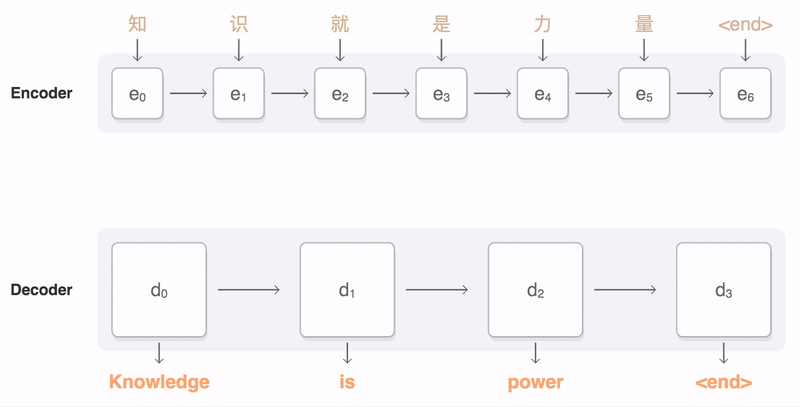

En estos modelos, la architecture principal es basada en modelos $seq2seq$ como se muestra en la figura de arriba.


Una faceta especial de generación de texto, es que ya que tienes un modelo que genera lenguaje. La manera en que lo usas al tiempo de decodificación importa mucho.

## Discusion

* Que estrategias de decodificacion han usado en el pasado?
* Que problemas puede haber con decodificar una palabra a la vez?
* Cual es el intercambio que se espera en diferentes estrategias? 

Si generaramos texto una palabra a la vez, un error o decisión temprana podría desviar el enunciado o parrafo.

In [37]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-multilingual-cased')

/usr/local/lib/python3.6/dist-packages/transformers/modeling_auto.py:798: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
beam_size =  1#@param
beam_size = min(beam_size, 5)
length =  5#@param
prompt = "Los trabajadores se reunieron"  #@param
beam = [(1.0, prompt)]
for step in range(length):
  new_beam = []
  while beam:
    prob, prompt = beam[0]
    mask_prompt = prompt + ' [MASK] .'
    beam = beam[1:]
    for b in range(beam_size):
      res = unmasker(mask_prompt)[b]
      score = res['score']
      token_str = res['token_str']
      new_beam.append((score * prob, prompt + ' ' + token_str))
  beam = sorted(new_beam, reverse=True)[:beam_size]
  print('Despues del paso %d, el beam tiene:' % step)
  print(beam)
  print()

Despues del paso 0, el beam tiene:
[(0.10708917677402496, 'Los trabajadores se reunieron a')]

Despues del paso 1, el beam tiene:
[(0.00451958882997755, 'Los trabajadores se reunieron a casa')]

Despues del paso 2, el beam tiene:
[(0.0007156433109822742, 'Los trabajadores se reunieron a casa casa')]

Despues del paso 3, el beam tiene:
[(0.0005231649104516408, 'Los trabajadores se reunieron a casa casa casa')]

Despues del paso 4, el beam tiene:
[(0.0002466587422865826, 'Los trabajadores se reunieron a casa casa casa casa')]



Esto se puede ver mas claro en el siguiente diagrama.

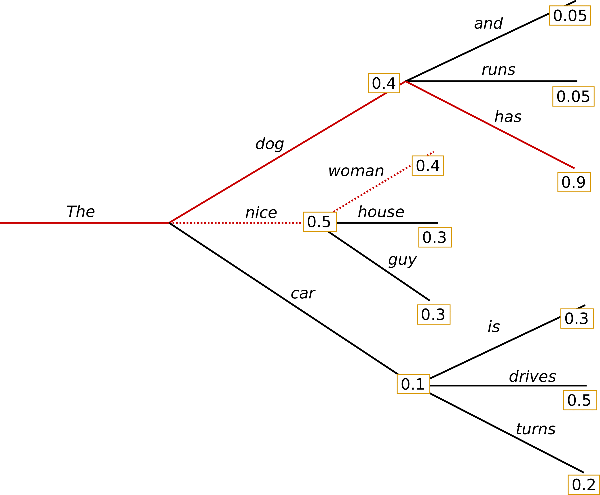

Pero a pesar de todo lo anterior, si los modelos siguen demasiado la distribución del lenguaje empiezan a generar texto que es muy "predecible". Es decir, cada palabra es  la más frequente en cada contexto: el niño siempre va camino a la escuela. La taza siempre tiene café.

Esto es un problema porque nosotros comunicamos texto que no sea obvio para el interlocutor, si es lo más obvio/frequente, lo omitimos. Esto se ha estudiado en el pasado y se conoce como sorpresa.
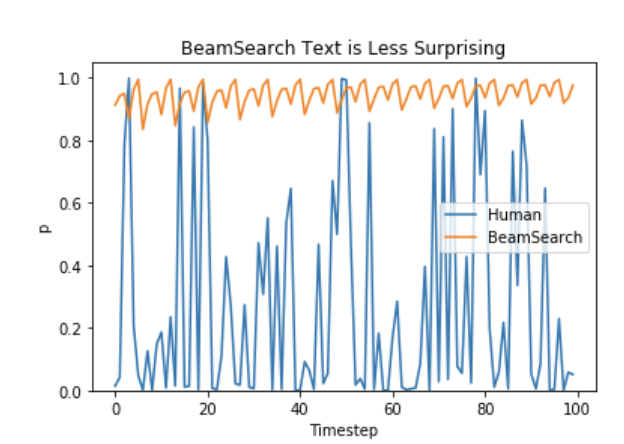

# El estado-del-arte en generación de resumenes: PEGASUS

In [80]:
!git clone https://github.com/google-research/pegasus
!pip install -e pegasus 
!export PYTHONPATH=.
%cd pegasus

Cloning into 'pegasus'...
remote: Enumerating objects: 171, done.
remote: Total 171 (delta 0), reused 0 (delta 0), pack-reused 171
Receiving objects: 100% (171/171), 353.09 KiB | 3.50 MiB/s, done.
Resolving deltas: 100% (56/56), done.
Obtaining file:///content/pegasus
     |████████████████████████████████| 51kB 4.1MB/s 
     |████████████████████████████████| 8.6MB 7.0MB/s 
     |████████████████████████████████| 3.5MB 36.9MB/s 
     |████████████████████████████████| 1.4MB 37.9MB/s 
     |████████████████████████████████| 411.0MB 34kB/s 
     |████████████████████████████████| 110.5MB 72kB/s 
     |████████████████████████████████| 368kB 40.9MB/s 
     |████████████████████████████████| 5.3MB 39.1MB/s 
     |████████████████████████████████| 655kB 30.8MB/s 
     |████████████████████████████████| 983kB 35.6MB/s 
     |████████████████████████████████| 81kB 5.9MB/s 
     |████████████████████████████████| 307kB 48.0MB/s 
     |████████████████████████████████| 184kB 32.7MB/s 
     |██

/content/pegasus


In [81]:
#@markdown Cambiemos la evaluación para que el output de las predicciones sea local.

%%writefile pegasus/eval/text_eval.py
# Copyright 2020 The PEGASUS Authors..
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Library for evaluating generative text models."""
import os
import re

from absl import logging
import numpy as np

from pegasus.eval.bleu import bleu_scorer
from pegasus.eval.length import length_scorer
from pegasus.eval.repetition import repetition_scorer
import tensorflow as tf

from rouge_score import rouge_scorer
from rouge_score import scoring
from tensorflow.contrib import summary as contrib_summary

_ROUGE_METRIC = "rouge"
_BLEU_METRIC = "bleu"
_REPETITION_METRIC = "repetition"
_LENGTH_METRIC = "length"

_LOG_EVERY_N = 1
_LINE_SEPARATOR = "-----:"


def ids2str(encoder, ids, num_reserved):
  """Decode ids."""
  if num_reserved:
    eos = np.where(ids == 1)[0]
    if np.any(eos):
      ids = ids[:eos[0]]
    reserved_tokens = np.where(ids < num_reserved)[0]
    if reserved_tokens.size:
      split_locations = np.union1d(reserved_tokens, reserved_tokens + 1)
      ids_list = np.split(ids, split_locations)
      text_list = [
          "<%d>" %
          i if len(i) == 1 and i < num_reserved else encoder.decode(i.tolist())
          for i in ids_list
      ]
      return " ".join(text_list)
  return encoder.decode(ids.flatten().tolist())


def decode_matrix(decode_fn, matrix):
  """Decode a matrix or vector."""
  if np.issubdtype(matrix.dtype, float):
    decode_fn = str
  num_dims = len(matrix.shape)
  if num_dims == 1:
    return decode_fn(matrix)
  elif num_dims == 2:
    return [decode_fn(v) for v in matrix]
  else:
    raise ValueError("Matrix dimensions has to be 1 or 2, got %d" % num_dims)


def decode_selected_indices(decode_fn, features):
  """Decode selected indices from features dict."""
  inputs = features.get("inputs", None)
  selected_ids = features.get("selected_ids", None)
  num_inputs = features.get("num_inputs", None)
  if inputs is None or selected_ids is None or num_inputs is None:
    raise ValueError("Insufficient input fields.")
  if len(inputs.shape) != 2:
    raise ValueError("Expected prediction['inputs'] to have two dimensions.")
  return "".join([
      "%d: %s\n" % (i, decode_fn(inputs[i]))
      for i in selected_ids
      if i >= 0 and i < num_inputs
  ])


class LogWriter(object):
  """Log Writer.

  Write logs given output keys, model_dir and evaluation steps.
  Will not write any log if enable_logging is False.
  """

  def __init__(self, additional_keys, model_dir, global_step, eval_tag,
               enable_logging):
    names = ("inputs", "targets", "predictions")
    self._filenames = {}
    for name in names + additional_keys:
      filename = os.path.join(
          model_dir, "{}-{}-{}.{}".format(name, global_step, eval_tag, "txt"))
      self._filenames[name] = filename
    self._file_handles_dict = {}
    self._enable_logging = enable_logging

  def __enter__(self):
    if self._enable_logging:
      self._file_handles_dict = {
          name: tf.io.gfile.GFile(filename, "w")
          for name, filename in self._filenames.items()
      }
    return self

  def __exit__(self, *unused_args):
    for f in self._file_handles_dict.values():
      f.close()

  def write(self, text_dict, i):
    if self._enable_logging:
      for key, text in text_dict.items():
        if isinstance(text, list):
          text = "\n".join(["[%d]:\n%s" % (j, t) for j, t in enumerate(text)])
        self._file_handles_dict[key].write("%s%d\n%s\n" %
                                           (_LINE_SEPARATOR, i, text))
        if i % _LOG_EVERY_N == 0:
          logging.error("%s: %s", key.upper(), text)


def text_eval(encoder,
              features_iter,
              model_dir,
              global_step,
              eval_tag,
              enable_logging,
              inputs_pattern="^inputs[0-9]*$",
              targets_key="targets",
              predictions_key="outputs",
              additional_keys=(),
              num_reserved=None):
  """Evaluates a set of text targets/predictions."""
  decode_fn = lambda x: ids2str(encoder, x, num_reserved)
  scorers_dict = {}
  scorers_dict[_ROUGE_METRIC] = rouge_scorer.RougeScorer(
      ["rouge1", "rouge2", "rougeL", "rougeLsum"], use_stemmer=True)
  scorers_dict[_BLEU_METRIC] = bleu_scorer.BleuScorer()
  scorers_dict[_REPETITION_METRIC] = repetition_scorer.RepetitionScorer(
      ["regs1", "regs2", "regs3", "regsTCR"])
  scorers_dict[_LENGTH_METRIC] = length_scorer.LengthScorer(["word", "char"])
  aggregators_dict = {k: scoring.BootstrapAggregator() for k in scorers_dict}

  model_dir = '../outputs'
  with LogWriter(additional_keys, model_dir, global_step, eval_tag,
                 enable_logging) as log_writer:
    for i, features in enumerate(features_iter):
      inputs_list = []
      for k in sorted(features):
        if re.match(inputs_pattern, k):
          single_inputs = decode_matrix(decode_fn, features[k])
          if isinstance(single_inputs, list):
            inputs_list.extend(single_inputs)
          else:
            inputs_list.append(single_inputs)

      inputs = "\n".join(inputs_list)
      targets = decode_fn(features[targets_key])
      preds = decode_fn(features[predictions_key])
      text_dict = {
          "inputs": inputs_list,
          "targets": targets,
          "predictions": preds
      }

      for key in additional_keys:
        if key == "selected_ids":
          text_dict[key] = decode_selected_indices(decode_fn, features)
        else:
          text_dict[key] = decode_matrix(decode_fn, features[key])

      log_writer.write(text_dict, i)

      for key, scorer in scorers_dict.items():
        scores_i = scorer.score(targets, preds)
        aggregators_dict[key].add_scores(scores_i)

  aggregates_dict = {k: v.aggregate() for k, v in aggregators_dict.items()}
  length_histograms = scorers_dict[_LENGTH_METRIC].histograms(as_string=True)
  _write_aggregates(model_dir, global_step, eval_tag, aggregates_dict,
                    length_histograms)
  _write_aggregate_summaries(model_dir, global_step, eval_tag, aggregates_dict)


def _write_aggregates(model_dir, global_step, eval_tag, aggregates_dict,
                      length_histograms):
  """Writes text metrics to a file."""

  output_filename = os.path.join(
      model_dir, "text_metrics-{}-{}.txt".format(global_step, eval_tag))
  with tf.gfile.Open(output_filename, "w") as f:
    for k, v in sorted(aggregates_dict[_ROUGE_METRIC].items()):
      f.write("%s-R,%f,%f,%f\n" %
              (k, v.low.recall, v.mid.recall, v.high.recall))
      f.write("%s-P,%f,%f,%f\n" %
              (k, v.low.precision, v.mid.precision, v.high.precision))
      f.write("%s-F,%f,%f,%f\n" %
              (k, v.low.fmeasure, v.mid.fmeasure, v.high.fmeasure))
    for k, v in sorted(aggregates_dict[_BLEU_METRIC].items()):
      f.write("%s,%f,%f,%f\n" % (k, v.low.bleu, v.mid.bleu, v.high.bleu))
    for k, v in sorted(aggregates_dict[_REPETITION_METRIC].items()):
      f.write("%s-T-token,%f,%f,%f\n" %
              (k, v.low.target_ratio, v.mid.target_ratio, v.high.target_ratio))
      f.write("%s-P-token,%f,%f,%f\n" %
              (k, v.low.prediction_ratio, v.mid.prediction_ratio,
               v.high.prediction_ratio))
    for k, v in sorted(aggregates_dict[_LENGTH_METRIC].items()):
      f.write(
          "%s-T,%f,%f,%f\n" %
          (k, v.low.target_length, v.mid.target_length, v.high.target_length))
      f.write("%s-P,%f,%f,%f\n" %
              (k, v.low.prediction_length, v.mid.prediction_length,
               v.high.prediction_length))
      f.write("%s-R,%f,%f,%f\n" %
              (k, v.low.relative_length, v.mid.relative_length,
               v.high.relative_length))
    for k, histogram in sorted(length_histograms.items()):
      f.write("%s-hist-T,%s\n" % (k, str(histogram.target)))
      f.write("%s-hist-P,%s\n" % (k, str(histogram.prediction)))
      f.write("%s-hist-R,%s\n" % (k, str(histogram.relative)))


def _write_aggregate_summaries(model_dir, global_step, eval_tag,
                               aggregates_dict):
  """Writes text metrics as summaries."""

  eval_dir = os.path.join(model_dir, eval_tag)
  summary_writer = contrib_summary.create_file_writer(eval_dir)
  with summary_writer.as_default(), \
      contrib_summary.always_record_summaries():
    for k, v in sorted(aggregates_dict[_ROUGE_METRIC].items()):
      contrib_summary.scalar(
          "text_eval/%s-R" % k, v.mid.recall, step=global_step)
      contrib_summary.scalar(
          "text_eval/%s-P" % k, v.mid.precision, step=global_step)
      contrib_summary.scalar(
          "text_eval/%s-F" % k, v.mid.fmeasure, step=global_step)
    for k, v in sorted(aggregates_dict[_BLEU_METRIC].items()):
      contrib_summary.scalar("text_eval/%s" % k, v.mid.bleu, step=global_step)
    for k, v in sorted(aggregates_dict[_REPETITION_METRIC].items()):
      contrib_summary.scalar(
          "text_eval/%s-T" % k, v.mid.target_ratio, step=global_step)
      contrib_summary.scalar(
          "text_eval/%s-P" % k, v.mid.prediction_ratio, step=global_step)
    for k, v in sorted(aggregates_dict[_LENGTH_METRIC].items()):
      contrib_summary.scalar(
          "text_eval/%s-T" % k, v.mid.target_length, step=global_step)
      contrib_summary.scalar(
          "text_eval/%s-P" % k, v.mid.prediction_length, step=global_step)
      contrib_summary.scalar(
          "text_eval/%s-R" % k, v.mid.relative_length, step=global_step)

Overwriting pegasus/eval/text_eval.py


In [82]:
#@markdown Veamos como quedo el archivo.
%pycat pegasus/eval/text_eval.py

In [83]:
#@markdown Creemos el directorio donde estaran las predicciones.
!mkdir ../outputs

In [84]:
#@markdown Verifiquemos que los datos estan en el GCP bucket. Imprimamos los primeros 5
filename = 'gs://pegasus-spanish/data/validation.tfrecord'
dataset = tf.data.TFRecordDataset([filename])

examples = []
for raw_record in dataset.take(5):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print('\tINPUT:\n' + example.features.feature['inputs'].bytes_list.value[0].decode('utf-8'))
  print('\tTARGET:\n' + example.features.feature['targets'].bytes_list.value[0].decode('utf-8'))
  print()

	INPUT:
Sally Forrest, an actress-dancer who graced the silver screen throughout the '40s and '50s in MGM musicals and films such as the 1956 noir While the City Sleeps died on March 15 at her home in Beverly Hills, California. Forrest, whose birth name was Katherine Feeney, was 86 and had long battled cancer. Her publicist, Judith Goffin, announced the news Thursday. Scroll down for video . Actress: Sally Forrest was in the 1951 Ida Lupino-directed film 'Hard, Fast and Beautiful' (left) and the 1956 Fritz Lang movie 'While the City Sleeps' A San Diego native, Forrest became a protege of Hollywood trailblazer Ida Lupino, who cast her in starring roles in films including the critical and commercial success Not Wanted, Never Fear and Hard, Fast and Beautiful. Some of Forrest's other film credits included Bannerline, Son of Sinbad, and Excuse My Dust, according to her iMDB page. The page also indicates Forrest was in multiple Climax! and Rawhide television episodes. Forrest appeared as he

In [85]:
#@markdown Corramos evaluacion en el tpu.
TPU_ADDRESS = os.environ['COLAB_TPU_ADDR']
!python3 pegasus/bin/evaluate.py --params=cnn_dailymail_transformer \
--param_overrides=vocab_filename=gs://pegasus-spanish/cnn_dailymail/c4.unigram.newline.10pct.96000.model,\
batch_size=8,beam_size=5,beam_alpha=0.6,\
dev_pattern=tfrecord:gs://pegasus-spanish/data/validation.tfrecord \
--model_dir=gs://pegasus-spanish/cnn_dailymail --use_tpu --master=grpc://$TPU_ADDRESS



Instructions for updating:
Use standard file APIs to check for files with this prefix.
W0826 12:25:37.459172 139743533090688 deprecation.py:323] From pegasus/bin/evaluate.py:85: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.

W0826 12:25:38.756182 139743533090688 module_wrapper.py:139] From /content/pegasus/pegasus/ops/public_parsing_ops.py:93: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0826 12:25:39.325183 139743533090688 module_wrapper.py:139] From /content/pegasus/pegasus/params/estimator_utils.py:49: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0826 12:25:39.326010 139743533090688 estimator.py:1994] Estimator's model_fn (<function _estimator_model_fn.<locals>.model_fn at 0x7f18128850d0>) includes params argument, but params are not passe

Veamos la calidad de los resumenes generados por nuestro modelo PEGASUS.

In [93]:
%load_ext google.colab.data_table
import pandas as pd
data = {}
for name in ('predictions', 'targets'):
  data[name] = open('../outputs/%s-210000-.dev.txt' % name, 'r').read()
  data[name] = [l for l in data[name].split('-----:') if l]
  data[name] = [l.split('\n', maxsplit=1)[1] for l in data[name]]

name = 'inputs'
data[name] = open('../outputs/%s-210000-.dev.txt' % name, 'r').read()
data[name] = [l for l in data[name].split('-----:') if l]
data[name] = [l.split(':\n', maxsplit=1)[1] for l in data[name]]

table = pd.DataFrame.from_dict(data)
table[:5]

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


,predictions,targets,inputs
0,Sally Forrest graced the silver screen through...,"Sally Forrest, an actress-dancer who graced th...","Sally Forrest, an actress-dancer who graced th..."
1,"Wang Lian, 35, collects leaves in Nanjing, eas...",Works include pictures of Presidential Palace ...,A middle-school teacher in China has inked hun...
2,"Iftekhar Murtaza, 30, was sentenced for the mu...","Iftekhar Murtaza, 29, was convicted a year ago...",A man convicted of killing the father and sist...
3,Fourth-in-line to the throne watched England b...,Prince Harry in attendance for England's crunc...,Avid rugby fan Prince Harry could barely watch...
4,"Nick Slater, 26, was flooded with 130 voicemai...",Nick Slater's colleagues uploaded a picture to...,A Triple M Radio producer has been inundated w...


Finalmente, analizaremos la calidad de los modelos en español. Los modelos entrenados para este taller resultaron no ser compatibles con la version open-source de Pegasus, por esta razon, usaremos el tiempo viendo las predicciones unicamente.

In [95]:
%ls es_predictions/

'inputs-19000-beam_alpha=0.8,beam_size=5.dev.txt'
'predictions-19000-beam_alpha=0.8,beam_size=5.dev.txt'
'targets-19000-beam_alpha=0.8,beam_size=5.dev.txt'


In [97]:
%load_ext google.colab.data_table

!mkdir es_predictions/
!gsutil cp -r gs://pegasus-spanish/es_data/predictions/* es_predictions/

import pandas as pd
data = {}
for name in ('predictions', 'targets'):
  data[name] = open('es_predictions/%s-19000-beam_alpha=0.8,beam_size=5.dev.txt' % name, 'r').read()
  data[name] = [l for l in data[name].split('-----:') if l]
  data[name] = [l.split('\n', maxsplit=1)[1] for l in data[name]]

name = 'inputs'
data[name] = open('es_predictions/%s-19000-beam_alpha=0.8,beam_size=5.dev.txt' % name, 'r').read()
data[name] = [l for l in data[name].split('-----:') if l]
data[name] = [l.split(':\n', maxsplit=1)[1] for l in data[name]]

table = pd.DataFrame.from_dict(data)
table[:10]

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table
mkdir: cannot create directory ‘es_predictions/’: File exists
Copying gs://pegasus-spanish/es_data/predictions/inputs-19000-beam_alpha=0.8,beam_size=5.dev.txt...
Copying gs://pegasus-spanish/es_data/predictions/predictions-19000-beam_alpha=0.8,beam_size=5.dev.txt...
Copying gs://pegasus-spanish/es_data/predictions/targets-19000-beam_alpha=0.8,beam_size=5.dev.txt...
/ [3 files][154.5 KiB/154.5 KiB]                                                
Operation completed over 3 objects/154.5 KiB.                                    


,predictions,targets,inputs
0,"La familia , de origen ecuatoriano , estaba ce...",El ni ⁇ o lleg ⁇ al hospital sin respiraci ⁇ ...,Un ni ⁇ o de tres a ⁇ os ha fallecido esta noc...
1,"La presentadora de Vallecas , acompa ⁇ ada del...",La presentadora cambi ⁇ su arriesgado dos pie...,El bikini de flores y tul de Cristina Pedroche...
2,La mujer ha sufrido un traumatismo craneoencef...,La mujer se despe ⁇ en el municipio de Algaid...,Una joven brit ⁇ nica de 25 a ⁇ os ha resultad...
3,Thielemann vuelve a recrearse en su visi ⁇ n s...,El alem ⁇ n Christian Thielemann ha sido el en...,Juan Carlos Galindo Con este comentario de nue...
4,Un hombre de 25 a ⁇ os ha sido detenido en est...,Detenido un hombre tras acuchillar a tres pers...,Agentes de polic ⁇ a detienen al atacante en M...
5,La Comunidad de Madrid volver ⁇ a congelar la...,Se mantiene también la tarifa plana de 20 euro...,La empresa p ⁇ blica Canal de Isabel II congel...
6,El artista pl ⁇ stico Jwan Yosef revela la not...,El cantante y su marido no han especificado de...,Ricky Martin ha recibido el a ⁇ o 2019 anuncia...
7,Los 81 a ⁇ os después de perder el ojo en un a...,Su canci ⁇ n m ⁇ s conocida fue 'When You 're ...,“ Quiero ver mi cara sonriente en la portada d...
8,"El presidente de la Comunidad de Madrid , ⁇ n...",Recurri ⁇ a ⁇ la invitaci ⁇ n a la conviven...,Discurso de Fin de A ⁇ o de ⁇ ngel Garrido . ...
9,"La polic ⁇ a inspecciona el coche , con el fro...",El agresor primero dice que es un acto terrori...,"La polic ⁇ a inspecciona el coche , con el fro..."


## Discusion

*  Que opiniones se forman acerca de la calidad actual de generadores de resumenes?
*  Que casos positivos o negativos ven en las predicciones?

# Conclusión

Espero salgan de aqui con una intuición de como generación de texto se lleva a cabo, cuales son los obstaculos más comunes y el nivel de calidad actual que se puede generar con redes neuronales profundas.

# Preguntas y respuestas.

1.  Como funciona el ajustado fino para modelos de generacion de texto?

2.  ...

# Referencias.

Debajo hay mas informacion acerca de los temas cubiertos por el taller.

1.   [Google AI blog](https://ai.googleblog.com/2020/06/pegasus-state-of-art-model-for.html) acerca de Pegasus
2.   Este [articulo](https://hackernoon.com/from-what-is-a-markov-model-to-here-is-how-markov-models-work-1ac5f4629b71) para aprender mas de cadenas de Markov
3.   Este [blog post](https://huggingface.co/blog/how-to-generate) de huggingface cubre muy bien las estrategias de decodificacion.
4.   Esta [publicacion](https://arxiv.org/abs/1904.09751) discute muchos problemas con generacion de texto y estrategias de decodificacion.